Shifted-Beta-Geometric (sBG) Customer Lifetime Value Model
================================


$$\\[2pt]$$


Igor Marfin **[Unister Gmb@2014]** < <igor.marfin@unister.de>>


$$\\[40pt]$$


Abstract
----------------


--------------------------


Idea of the  analysis was taken from the blog [[1]](#Blog):

>The academic literature on the Lifetime Value  (LTV) Model breaks down the problem into four scenarios, depending on whether the customer-business relationship is contractual, and on whether customers have discrete opportunities for transactions. 


>we are  going to implement a model from the contractual-discrete (lower-right) quadrant: the shifted-beta-geometric (sBG) model.



$$\\[5pt]$$
### Contractual-Discrete: The sBG Model

The shifted-beta-geometric (sBG) model makes two assumptions:

* Each customer has a constant churn probability $\theta$. You can think of this as the customer flipping a weighted coin (with probability of tails =  $\theta$) at the end of every subscription period, and they cancel their membership if the coin lands tails.
* Customer churn probabilities are drawn from a beta distribution with parameters  $\alpha$ and $\beta$.


We are going to make sBG Model using PyMC.

More details can be found at https://bitbucket.org/iggy_floyd/bayesian-pymc-sbg-livetime-customer-model.

$$\\[5pt]$$
Outline
------------------


------------------


* Abstract
   * Contractual-Discrete: The sBG Model
* Initialization of the notebook
* Getting and cleaning the data
* The Model
* Diagnostics
* Discounted Expected Residual Lifetime (DERL)
* References

$$\\[5pt]$$
Initialization 
--------------------------

________

To set up the python environment for the data analysis and make a nicer style of the notebook, one can run the following commands in the beginning of our modeling:


In [1]:
import sys
sys.path = ['/usr/local/lib/python2.7/dist-packages'] + sys.path # to fix the problem with numpy: this replaces  1.6 version by 1.9

%matplotlib inline
%pylab inline
ion()

import os
import matplotlib 
import numpy as np
import matplotlib.pyplot as pl
import matplotlib as mpl
import logging
import pymc as pm

# a plotter and dataframe modules
import seaborn as  sns # seaborn to make a nice plots of the data
import pandas as pd
import scipy.stats as stats





# Set up logging.
logger = logging.getLogger()
logger.setLevel(logging.INFO)

from book_format import load_style, figsize, set_figsize
load_style()



Populating the interactive namespace from numpy and matplotlib


$$\\[5pt]$$
Getting and cleaning the data
-------------


--------------------------


We imagine that there is a company "Unister Gmbh" which provide one services/subscription: it books flight tickets and a membership for the customers in the company costs 10€ per month. Also the company provides 10% discount for each customers after 2nd month of their membership.

The bussiness results have shown not nice numbers, and
after some period of the working, the management of the company has decided to 
estimate and predict the "churn" (a decision on cancelation of the memberships) behavior of their customers. 

Another crusial task of the managers was a try to estimate 
the amount of money which can be brought by customers.

Let's assume the management of the company has aggregated data on the number of customers
signed to the service for the last 8 months. Then they have randomly chosen 1000 customers and decided to track their behaviour for this 8-month period: if the customer was signed to the service or had canceled the contract in the end of each month.

In [2]:
# numbers from CRM department of the Unister GmbH ... :-)
num_customers = np.array([1000, 869, 743, 653, 593, 551, 517, 491]) 
num_periods = len(num_customers)

Then we find out how many customers left, and aggregate all data in one dataframe:

In [3]:
previous_data = np.roll(num_customers, -1)
lost_customers = num_customers - previous_data
lost_customers = np.r_[[None],lost_customers[:-1]]
customer_data = pd.DataFrame({
        "active":num_customers, # customers which are still active
        "lost":lost_customers, # customers left after each control sub-period (month)
    })

$$\\[5pt]$$
The Model
------------------


--------------------

Our model is defined as follows:

In [4]:
#defines the class for the Modeling
class Model(object):
    """ A Model class 
         :param np.ndarray data: The  data to use for learning the model.
         
    """



    def __init__(self, data):        
    
        logging.info('building the  model....') 
        

        # how many periods of the measurement we have
        self.num_periods = len(data)

        # parameters of our model
        self.alpha = pm.Uniform('alpha', 0.00001, 1000, value=1)  # parameters of the probability model 
        self.beta = pm.Uniform('beta', 0.00001, 1000, value=1) # 


        # determines the probability that randomly chosen customer leaves the company after some each t period
        @pm.deterministic
        def P_T_is_t(alpha=self.alpha, beta=self.beta, num_periods=self.num_periods):
            p = [None, alpha / (alpha + beta)] #why alpha? maybe beta?
            #p = [None, beta / (alpha + beta)] 
            for t in range(2, num_periods):
                pt = (beta + t - 2) / (alpha + beta + t - 1) * p[t-1]
                p.append(pt)
            return p

        # this is probability of a  randomly chosen individual survives to period t given alpha and beta
        @pm.deterministic
        def survival_function(P_T_is_t=P_T_is_t, num_periods=num_periods):
            s = [None, 1 - P_T_is_t[1]]
            for t in range(2, num_periods):
                s.append(s[t-1] - P_T_is_t[t]) # iteration: survival[k] = survival[k-1] - proba_to_leave[k-1]  
            return s
        

        
        # likelihood function: P_T_is_t[:]*survival_function[-1]
        # here P_T_is_t[:] is a product of type: (p_1)^N_1 x (p_2)^N_2 x... where (p_i,N_i) are a probability and number of customers
        # to leave (die) the company
        #
        # survival_function[-1] --> (s_-1)^N(active)_-1 
        # s_-1 -- survived function (or survived proba) and N(active)_-1 -- active customers to the
        # end of the last  period 

        #
        # As a summary: this is a Bernoulli model: (p_1)^N_1 x (p_2)^N_2..x survival_function[-1]
        
        @pm.observed
        def retention_rates(P_T_is_t=P_T_is_t, survival_function=survival_function, value=data):
            def logp(value, P_T_is_t, survival_function):
                        
                active, lost = value.T[0],value.T[1]
        
                # Those who've churned along the way...
                # i.e, died:
                # their Log(L_died) is Log(Proba_to_leave_i), where i is an index over all 'lost' customers
                died = np.log(P_T_is_t[1:]) * lost[1:]  #is a numpy array
        
                # and those still active in last period
                still_active = np.log(survival_function[-1]) * active[-1]              
            
                # LogLikelihood is sum of the died for each month and still_active in the last period
                return sum(died) + still_active
        
        # build a model    
        self.model = pm.MCMC([self.alpha, self.beta, P_T_is_t, survival_function, retention_rates])
        

What doest `P_T_is_t` function mean? It corresponds to the formula 
$$
(p_1)^{N_1} \times (p_2)^{N_2} \times...,$$ 
where $(p_i,N_i)$ are a probability and number of customers  left (died) the company.
The interesting thing here is that $p_{i+1}=p_i\times \frac{\beta+t_{i-1}}{\alpha+\beta+t_{i}}.$

`survival_function` converserly defines the probability for the customer to continue
using the service of the company in each next month.

The model is a simple  a Bernoulli model: 
>(p_1)^N_1 x (p_2)^N_2..x survival_function[-1]


In [5]:
chunk_customers_model=Model(customer_data)
chunk_customers_model.model.sample(20000, 5000, 20)

INFO:root:building the  model....


 [-----------------100%-----------------] 20000 of 20000 complete in 3.7 sec

$$\\[5pt]$$
Diagnostics
------------------


--------------------

Let's see if/how the model converged. 

Plotting alpha
Plotting beta


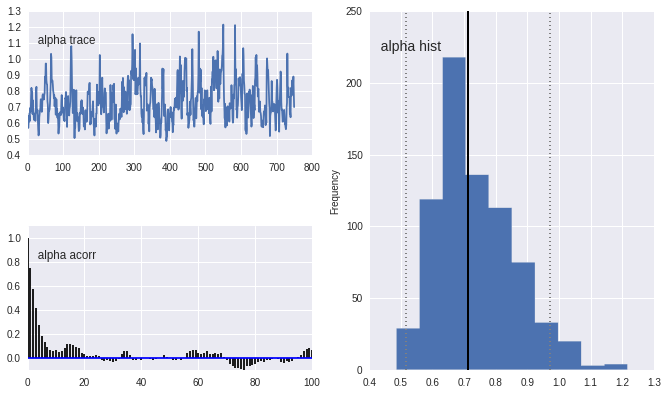

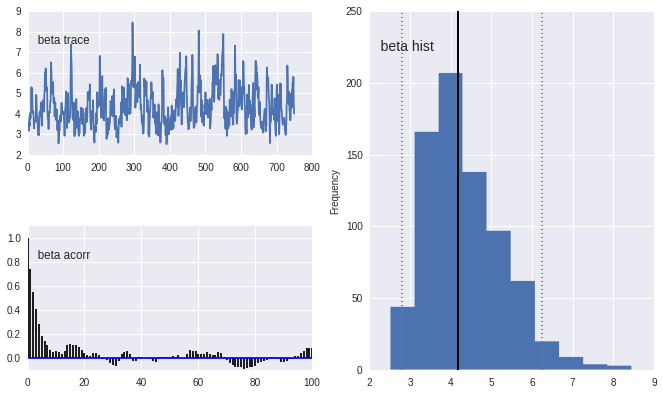

In [6]:
sns.set(style="darkgrid")


#  alpha parameter
pm.Matplot.plot(chunk_customers_model.alpha)

#  beta parameter
pm.Matplot.plot(chunk_customers_model.beta)

$$\\[5pt]$$
Discounted Expected Residual Lifetime (DERL)
----------------------

-------


>The motivation for the DERL is that once you've fit an sBG model to a customer base, an obvious follow up question is, "how much money can I expect to take in from this customer base in the future?" The DERL for a customer who pays $x$ Euro per period and who is life (not left company) at the end of the $n^{th}$ period is the number such that $DERL\times x$ is the expected present value of future payments from that customer. The DERL is a function of $\alpha, \beta,$ a discount rate $d$, and the current period $n$ of the subscriber.


The DERL can also give us the expected discounted CLV of a new customer, if we set $n=1$ and add an undiscounted initial payment. And because we have posterior distributions for $\alpha$ and $\beta$, we can easily leverage our uncertainty in $\alpha$ and $\beta$ to understand our uncertainty in the statistic we really care about, the CLV, i.e. the money which the customer brings to our company in the future.
The calculation of $DERL\times x$ will answer on the second qestion formulated by the 
management of the company.

The DERL function is defined as follows:

In [7]:
from scipy.special import hyp2f1

def _derl(self,alpha, beta, d, n):
    """
    Discounted Expected Residual Lifetime, as derived in Fader and Hardie (2010).  See equation (6).

    :param alpha: sBG alpha param
    :param beta: sBG beta param
    :param d: discount rate
    :param n: customer's contract period (customer has made n-1 renewals)
    :return: float
    """
    return (beta + n - 1) / (alpha + beta + n - 1) * hyp2f1(1, beta + n, alpha + beta + n, 1 / (1 + d))


def _prepare_trace(self):
    ''' prepare a dataframe with traces of the alpha and beta parameters of 
    our model
    '''
    self.traces = pd.DataFrame({'alpha': self.alpha.trace(), 'beta': self.beta.trace()})

def _derl_mcmc(self,n=1,d=.1,cost=10):
    '''
        builds MCMC traces for DERL and DERL x Cost as functions of the sub-period
        n and the discount d.
    '''
    
    derl_label="DERL"+"_"+str(d)+"_"+str(n)
    self.traces[derl_label] =  self.traces.apply(lambda x: 1 + self.derl(x['alpha'], x['beta'], d, n), axis=1)
    ltv_label = "LTV"+"_"+str(d)+"_"+str(n)
    self.traces[ltv_label] = float(cost) *self.traces[derl_label]
    return (derl_label,ltv_label)
    
    
# Update the definition of the Model Class
Model.derl = _derl
Model.prepare_trace = _prepare_trace
Model.derl_mcmc = _derl_mcmc




Let's calculate how much money could bring the new customer in  the beginning of the period.

In [8]:
n=1. # a customer is alive to the end of the 1st month
cost=10. # the price of the membership
d=0.1 #  discount 10%


chunk_customers_model.prepare_trace()
derl_label,ltv_label = chunk_customers_model.derl_mcmc(n,d,cost)


To demonstrate DERL Value,we make the function which will plot posterior distribution of the DERL value.

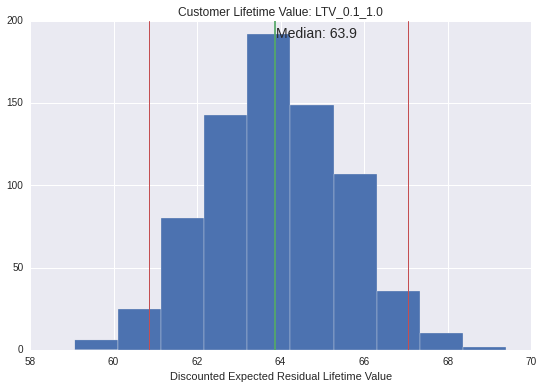

In [9]:
def plot_derl_value(df_trace,ltv_label):
    ''' plots DERL value posterior distribution for the 
        customers data given by df_trace
    '''
    
    # plot 95% CL HDI
    median_clv = df_trace[ltv_label].median()
    cred_interval = df_trace[ltv_label].quantile(.025),df_trace[ltv_label].quantile(.975)
    ax = df_trace[ltv_label].hist()
    ax.set_title('Customer Lifetime Value: %s'%ltv_label)
    ax.set_xlabel('Discounted Expected Residual Lifetime Value')
    ax.plot([median_clv, median_clv], ax.get_ylim())
    plt.annotate('Median: %.1f' % median_clv, xy=(median_clv + .02, ax.get_ylim()[1]-10))
    ax.plot([cred_interval[0], cred_interval[0]], ax.get_ylim(), c=sns.color_palette()[2], lw=1)
    _ = ax.plot([cred_interval[1], cred_interval[1]], ax.get_ylim(), c=sns.color_palette()[2], lw=1)

    

plot_derl_value(chunk_customers_model.traces,ltv_label)    

Wow! The newcoming customer would bring about 64 Euro to the company before he or she will cancel the membership.

Ok. This is a nice result if the Unister Gmbh has millions of the customers. 
This 64 Euro also tells us about median of life-time for the customer, it is about 6.4 months.


If the customer has decided after the 1st month of the membership to prolongate the contract, how much money the company will earn from this membership then?



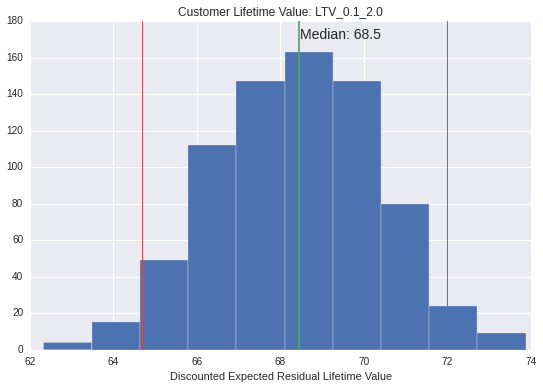

In [10]:
n=2. # a customer is alive to the end of the 2nd month
cost=10. # the price of the membership
d=0.1 #  discount 10%

derl_label,ltv_label = chunk_customers_model.derl_mcmc(n,d,cost)
plot_derl_value(chunk_customers_model.traces,ltv_label)

Now we expect that the customer likes the service and he/she will bring us about 69 Euro.


Imagine, that the top management of "Unister Gmbh" wants to understand what the income of the company would be (predicted) from all customers registered in the system at that moment.


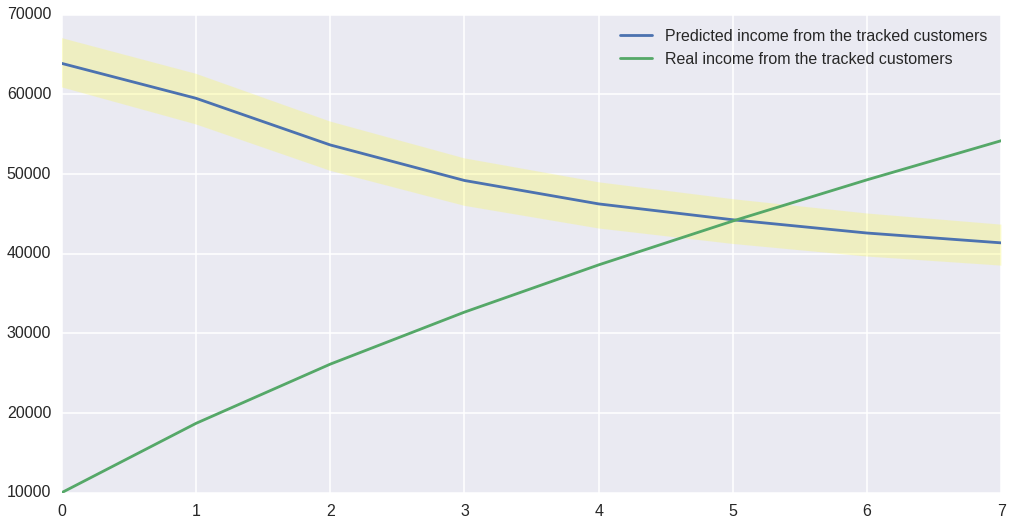

In [11]:
def plot_predicted_income(model,customer_data,d=0.1,cost=10.):
    ''' makes plots of the predicted income '''
    
    
    sns.set_context("poster")
    plt.figure(figsize=(15,8))
    
    active = customer_data["active"].values
    lost = customer_data["lost"].values
    num_periods = len(active)
    ltvs = np.array([            
                model.traces[
                    model.derl_mcmc(i+1,d,cost)[1]
                ].median()                                
                for i in range(num_periods)
            ])
    
    cred_interval_low =  np.array([            
                model.traces[
                    model.derl_mcmc(i+1,d,cost)[1]
                ].quantile(.025)                             
                for i in range(num_periods)
            ])
    
    cred_interval_low *= active
    cred_interval_high =  np.array([            
                model.traces[
                    model.derl_mcmc(i+1,d,cost)[1]
                ].quantile(.975)                             
                for i in range(num_periods)
            ])
    
    cred_interval_high *= active
    ltvs*=active     
    real_income = cost*active;
    real_income = np.cumsum(real_income)
    pl.plot(np.array(range(num_periods)),ltvs,label='Predicted income from the tracked customers')
    pl.fill_between(np.array(range(num_periods)), cred_interval_low,cred_interval_high ,
                     facecolor='yellow',alpha=0.2,label='68% CL')
    pl.plot(np.array(range(num_periods)),real_income,label='Real income from the tracked customers')
    pl.legend()

plot_predicted_income(chunk_customers_model,customer_data)
    

So, looking at the plot above, one of the manager could say (in April, it is the sub-period "3"):
> Ok, guys, our sample group of 1000 customers has brought us about 32K Euro up-to now and we expect to get about [45,52]K more from them. 

There is about 7K uncertainty of the predicted income hidden in the words above.


** The last points of this study is investigation of the role of the sample size.** 

Somebody in the management of the company has decided to increase the control group used to model the chunk behaviour of the customers. He has decided to use 10K customers in the beginning the period.

In [12]:

# numbers from CRM department of the Unister GmbH ... :-)
num_customers_10K = np.array([1000, 869, 743, 653, 593, 551, 517, 491]) 
num_customers_10K =10*num_customers_10K # the top manager has decided....

previous_data_10K = np.roll(num_customers_10K, -1)
lost_customers_10K = num_customers_10K - previous_data_10K
lost_customers_10K = np.r_[[None],lost_customers_10K[:-1]]
customer_data_10K = pd.DataFrame({
        "active":num_customers_10K, # customers which are still active
        "lost":lost_customers_10K, # customers left after each control sub-period (month)
    })


chunk_customers_model_10K=Model(customer_data_10K)
chunk_customers_model_10K.model.sample(20000, 5000, 20)

INFO:root:building the  model....


 [-----------------100%-----------------] 20000 of 20000 complete in 3.9 sec

Then using this model, he has plotted again the predicted income as a function of the month in the control period:

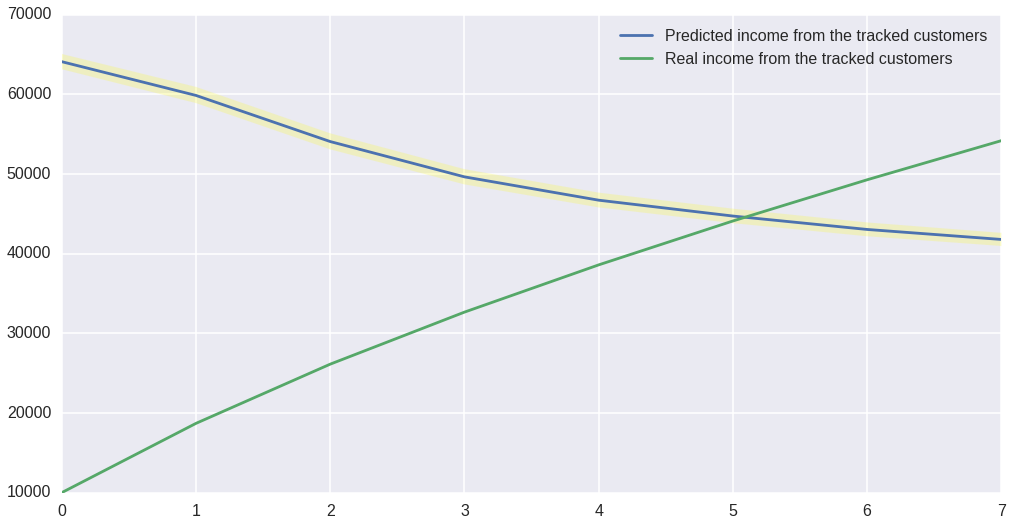

In [13]:
chunk_customers_model_10K.prepare_trace()
plot_predicted_income(chunk_customers_model_10K,customer_data)

... and the uncertainty on the predicted income was significantly decreased.

$$\\[5pt]$$
References
----------------------

-------


<a id='Blog'></a>
[[1]http://danielweitzenfeld.github.io/passtheroc/blog/2015/01/19/s-b-g/]( http://danielweitzenfeld.github.io/passtheroc/blog/2015/01/19/s-b-g/)



